# 【課題】量子計算

```{contents} 目次
---
local: true
---
```

$\newcommand{ket}[1]{|#1\rangle}$

## 問題1: 足し算を実機で行う

実習の内容の延長です。ここでは並列足し算回路を実機で実行します。

実習のおさらいをすると、まずもともとの足し算のロジックをそのまま踏襲した回路を作り、それではゲート数が多すぎるので効率化した回路を作成しました。

実は効率化した回路でもまだゲートの数が多すぎて、4ビット+4ビットの計算では答えがスクランブルされてしまいます。回路が小規模になればそれだけ成功確率も上がりますので、$(n_1, n_2)$の値として(4, 4)以外に(3, 3)、(2, 2)、(1, 1)も同時に試すことにしましょう。

In [1]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, Aer, transpile, assemble, execute
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from utils.optimized_additions import optimized_additions, get_initial_layout

print('notebook ready')

notebook ready


In [2]:
#IBMQ.enable_account('__paste_your_token_here__')
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

実習を参考に、次のセルで効率化前の回路を返す`make_original_circuit`関数を実装してください。

In [11]:
def make_original_circuit(n1, n2):
    """A function to define a circuit with the original implementation of additions given n1 and n2
    """
    n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

    reg1 = QuantumRegister(n1, 'r1')
    reg2 = QuantumRegister(n2, 'r2')
    reg3 = QuantumRegister(n3, 'r3')
    creg = ClassicalRegister(n1 + n2 + n3)

    # QuantumCircuit can be instantiated from multiple registers
    circuit = QuantumCircuit(reg1, reg2, reg3, creg)
    
    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?

    ##################
    ### EDIT ABOVE ###
    ##################

    return circuit


# 4 + 4 + 5 = 13量子ビット以上のマシンで ibm-q/open/main からアクセス可能なのはibmq_16_melbourneのみ（2021年3月現在）
backend = provider.get_backend('ibmq_16_melbourne')

# List of circuits
circuits = []

for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
    print('Original circuit with n1, n2 = {}, {}'.format(n1, n2))
    circuit = make_original_circuit(n1, n2)
    
    print('  Transpiling..')
    circuit = transpile(circuit, backend=backend, optimization_level=3)
    print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
    circuit.name = 'original_{}_{}'.format(n1, n2)
    circuits.append(circuit)

    print('Optimized circuit with n1, n2 = {}, {}'.format(n1, n2))    
    circuit = optimized_additions(n1, n2)

    print('  Transpiling..')
    initial_layout = get_initial_layout(backend, n1, n2)
    circuit = transpile(circuit, backend=backend, routing_method='basic', initial_layout=initial_layout, optimization_level=3)
    print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
    circuit.name = 'optimized_{}_{}'.format(n1, n2)
    circuits.append(circuit)

shots = 8192    
    
print('Submitting {} circuits to {}'.format(len(circuits), backend.name()))
qobj = assemble(circuits, backend=backend, shots=shots)    
job = backend.run(qobj)

job_monitor(job, interval=2)

counts_list = job.result().get_counts()

Original circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=328, N(SX)=270, N(CNOT)=216
Optimized circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=147, N(SX)=72, N(CNOT)=142
Original circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=172, N(SX)=120, N(CNOT)=160
Optimized circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=98, N(SX)=54, N(CNOT)=84
Original circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=121, N(SX)=96, N(CNOT)=68
Optimized circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=60, N(SX)=35, N(CNOT)=41
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=35, N(SX)=29, N(CNOT)=15
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=27, N(SX)=16, N(CNOT)=13
Submitting 8 circuits to ibmq_16_melbourne


ジョブが返ってきたら、8192ショットのうち正しい足し算を表しているものがどれだけあるか調べてみましょう。

In [ ]:
def count_correct_additions(counts_list, n1, n2, shots):
    for counts, ctype in zip(counts_list, ['Original ', 'Optimized']):
        correct_additions = 0

        for key, value in counts.items():
            x1 = int(key[-n1:], 2)
            x2 = int(key[-n1 - n2:-n1], 2)
            x3 = int(key[:-n1 - n2], 2)

            if x1 + x2 == x3:
                correct_additions += value
            
        print('{} circuit ({}, {}): {} / 8192 = {}'.format(ctype, n1, n2, correct_additions, correct_additions / shots))

icirc = 0
for n1, n2 in [(4, 4), (3, 3), (2, 2), (1, 1)]:
    count_correct_additions(counts_list[icirc:icirc + 2], n1, n2, shots)
    icirc += 2

回路が均一にランダムに$0$から$2^{n_1 + n_2 + n_3} - 1$までの数を返す場合、レジスタ1と2のそれぞれの値の組み合わせに対して正しいレジスタ3の値が一つあるので、正答率は$2^{n_1 + n_2} / 2^{n_1 + n_2 + n_3} = 2^{-n_3}$となります。実機の結果と比べてみると、(4, 4), (3, 3), (2, 2)では残念ながら元の回路も効率化した回路も正答率がほとんどこの値に近くなっているのがわかります。かろうじて(1, 1)において正答率がランダムなケース（$2^{-2}$）より高くなっています。

### Quantum Volume

実は上のテストをIBMの提供するより高性能なマシンで実行すると、元の回路と効率化した回路とで正答率が異なることが見えます。$(n_1, n_2)$ = (1, 1)に関しては効率化回路のほうがCNOTが少しだけ多くなるケースがあり、その場合実際に元の回路の正答率のほうが高くなります。例としてibmq_torontoというマシンで実行した結果は以下のとおりです。

In [ ]:
message = '''Original circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=370, N(SX)=313, N(CNOT)=290
Optimized circuit with n1, n2 = 4, 4
  Transpiling..
  Done. Ops: N(Rz)=142, N(SX)=71, N(CNOT)=142
Original circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=203, N(SX)=164, N(CNOT)=183
Optimized circuit with n1, n2 = 3, 3
  Transpiling..
  Done. Ops: N(Rz)=95, N(SX)=53, N(CNOT)=84
Original circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=104, N(SX)=74, N(CNOT)=81
Optimized circuit with n1, n2 = 2, 2
  Transpiling..
  Done. Ops: N(Rz)=60, N(SX)=35, N(CNOT)=41
Original circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=36, N(SX)=30, N(CNOT)=12
Optimized circuit with n1, n2 = 1, 1
  Transpiling..
  Done. Ops: N(Rz)=25, N(SX)=14, N(CNOT)=13
'''
print(message)

In [ ]:
message = '''Original  circuit (4, 4): 289 / 8192 = 0.0352783203125
Optimized circuit (4, 4): 340 / 8192 = 0.04150390625
Original  circuit (3, 3): 531 / 8192 = 0.0648193359375
Optimized circuit \x1b[31m(3, 3)\x1b[0m: 960 / 8192 = \x1b[31m0.1171875\x1b[0m
Original  circuit (2, 2): 1250 / 8192 = 0.152587890625
Optimized circuit \x1b[31m(2, 2)\x1b[0m: 1984 / 8192 = \x1b[31m0.2421875\x1b[0m
Original  circuit \x1b[31m(1, 1)\x1b[0m: 6114 / 8192 = \x1b[31m0.746337890625\x1b[0m
Optimized circuit \x1b[31m(1, 1)\x1b[0m: 5288 / 8192 = \x1b[31m0.6455078125\x1b[0m
'''
print(message)

効率化した回路では(3, 3)の段階（回路3）で、すでに正答率が$2^{-4}$を大きく上回っているのがわかります。

IBMQでは量子コンピュータ一つ一つをQuantum Volume（QV、量子体積）という指標で評価しています[^qv]。QVは簡単に言えば「量子コンピュータ上である特定の形を持った回路を安定的に実行できる量子ビット数と回路の長さ」を測っていて、QVの値が大きいマシンほど高性能と言えます。QVは全体の量子ビット数だけではなく、量子ビット間の接続度合、（特に制御ゲートの）エラー率、トランスパイラの性能などを総合的に評価します。

2021年3月現在、IBMQのマシンでQVの最大値は128ですが、ibmq_16_melbourneのQVは8です。QVの値は2の実効量子ビット数乗と考えればよく、これはつまり（かなり乱暴に言うと）15ビットマシンibmq_16_melbourneの上で信頼度高く実行できるのは3量子ビット回路までだということを意味します。

上で利用したibmq_torontoのQVは32でした。量子ビット数が少ないマシンであればopenのアカウントでもQV=32のマシンが複数存在するので、そのどれかを使って$(n_1, n_2)$ = (1, 1)の足し算を走らせてみましょう。

[^qv]: QVはハードウェアの詳細に依存しないように定義されているので、量子ビット型の量子コンピュータであればIBMのマシンに限らずすべてQVで評価できます。実際、業界で徐々にQVを標準ベンチマークとして使う動きが広がってきているようです。

In [3]:
backend_filter = lambda b: (not b.configuration().simulator) and b.configuration().n_qubits >= 4 and b.configuration().quantum_volume >= 32 and b.status().operational
backend = least_busy(provider.backends(filters=backend_filter))

print('Using backend', backend.name())

Using backend ibmq_santiago


In [ ]:
n1 = n2 = 1

circuits = []

print('Original circuit with n1, n2 = {}, {}'.format(n1, n2))
circuit = make_original_circuit(n1, n2)
print('  Transpiling..')
circuit = transpile(circuit, backend=backend, optimization_level=3)
print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
circuit.name = 'original_{}_{}'.format(n1, n2)
circuits.append(circuit)

print('Optimized circuit with n1, n2 = {}, {}'.format(n1, n2))    
circuit = optimized_additions(n1, n2)
print('  Transpiling..')
initial_layout = get_initial_layout(backend, n1, n2)
circuit = transpile(circuit, backend=backend, routing_method='basic', initial_layout=initial_layout, optimization_level=3)
print('  Done. Ops: N(Rz)={rz}, N(SX)={sx}, N(CNOT)={cx}'.format(**circuit.count_ops()))
circuit.name = 'optimized_{}_{}'.format(n1, n2)
circuits.append(circuit)

print('Submitting circuits')
qobj = assemble(circuits, backend=backend, shots=shots)    
job = backend.run(qobj)

job_monitor(job, interval=2)

counts_list = job.result().get_counts()

count_correct_additions(counts_list, n1, n2, shots)

ibmq_16_melbourneを使った場合と比べて、正答率はどうでしょうか？

完全にランダム（正答率0.25）よりはいい結果が得られるはずなので、公開されているバックエンドのエラー率から正答率を予想し、結果と照らし合わせてみましょう。

IBMQの各バックエンドに対して、次の3種類のエラー率が公開されています。

- 1量子ビットゲート（$X$とSX）の量子ビットごとのエラー率
- CNOTの量子ビット間接続ごとのエラー率
- 測定の量子ビットごとのエラー率

これまで触れて来ませんでしたが、測定自体でもエラーが起こる余地があります。測定のエラーとは、具体的には状態$\ket{0}$や$\ket{1}$を測定したときにどのくらいの割合で0や1でない結果を得るかということを表した値です。

バックエンドのエラー率は`backend.properties()`メソッドから取り出します。

In [4]:
def get_error_rates(backend, n1, n2):
    initial_layout = get_initial_layout(backend, n1, n2)

    links = []
    for iq in range(len(initial_layout) - 1):
        links.append((initial_layout[iq], initial_layout[iq + 1]))
        links.append((initial_layout[iq + 1], initial_layout[iq]))

    properties = backend.properties()

    sx_error = dict()
    cx_error = dict()
    meas_error = dict()

    for gate in properties.gates:
        if gate.gate == 'sx':
            qubit = gate.qubits[0]
            if qubit not in initial_layout:
                continue
            
            for param in gate.parameters:
                if param.name == 'gate_error':
                    sx_error[qubit] = param.value
                
        elif gate.gate == 'cx':
            link = tuple(gate.qubits)
            if link not in links:
                continue

            for param in gate.parameters:
                if param.name == 'gate_error':
                    cx_error[link] = param.value

    for qubit in initial_layout:
        qprops = properties.qubits[qubit]

        for prop in qprops:
            if prop.name == 'readout_error':
                meas_error[qubit] = prop.value
                
    return sx_error, cx_error, meas_error

sx_error, cx_error, meas_error = get_error_rates(backend, n1, n2)
print(sx_error)
print(cx_error)
print(meas_error)

{0: 0.00033605750179047865, 1: 0.0003313294216129223, 2: 0.00022401941521222202, 3: 0.00032770014751989354}
{(2, 3): 0.006640626202415623, (3, 2): 0.006640626202415623, (2, 1): 0.008443153050192997, (1, 2): 0.008443153050192997, (0, 1): 0.007931999600553963, (1, 0): 0.007931999600553963}
{0: 0.0353, 1: 0.056499999999999995, 2: 0.0121, 3: 0.014000000000000012}


In [ ]:
def predict_correct_fraction(sx_error, cx_error, meas_error):
    pass

mention: taking a mean for cx errors, meas errors larger and more variant, sx errors can be ignored
skeleton code: guide through: 0 error, 1 error, >= 2 errors

**提出するもの**

- `make_original_circuit`関数のコード
- 実機で各回路を実行した結果
- エラー率から正答率を予想する

## 問題2: 符号が反転している基底を見つける

実習で出てきたequal superposition状態

$$
H^{\otimes n} \ket{0} = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k}
$$

をそのまま測定すると、全ての整数$k$に対応するビット列が等しい確率で現れます。測定でビット列が現れる確率はそのビット列に対応する計算基底の振幅の絶対値自乗で決まるので、重ね合わせにおいてある整数$\tilde{k}$の符号だけ逆転している以下の状態でもやはり全ての整数が確率$1/2^n$で得られます。

$$
\frac{1}{\sqrt{2^n}} \left( \sum_{k \neq \tilde{k}} \ket{k} - \ket{\tilde{k}} \right)
$$

（一般には、全ての計算基底にバラバラに位相因子$e^{i\theta_{k}}$がかかっていても確率は同じです。）

さて、{doc}`後の実習 <grover>`で登場するグローバー探索というアルゴリズムは、上のように一つの計算基底の符号を逆転させるブラックボックス演算子（どの基底かは事前に知られていない）が与えられたときに、符号の反転が起こっている計算基底を効率よく見つけ出すための手法です。グローバー探索を利用すると、例えば$N$個のエントリーのあるデータベースから特定のエントリーを探し出すのに、$\mathcal{O}(\sqrt{N})$回データベースを参照すればいいということがわかっています。

今から考えるのはそのような効率的な方法ではなく、同じようにブラックボックス演算子が与えられたときに、原理的には符号の反転が起こっている基底を見つけることができる、という手法です。そのために振幅の干渉を利用します。

まずは具体性のために$n=3$として、ブラックボックスは$k=5$の符号を反転させるとします。ここでブラックボックスの中身が完全に明かされてしまっていますが、これは実装上の都合で、重要なのは検索アルゴリズムが中身（5）を一切参照しないということです。

後で便利なように、まずはブラックボックスを単体の回路として定義します。

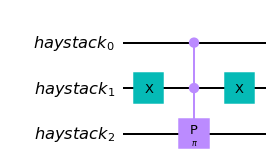

In [2]:
num_qubits = 3
needle = 5

haystack_register = QuantumRegister(num_qubits, name='haystack') # ビット数を指定してレジスタを作る
blackbox_circuit = QuantumCircuit(haystack_register, name='blackbox') # これまでの例と異なり、ビット数ではなくレジスタを指定して回路を作る

for i in range(num_qubits):
    if ((needle >> i) & 1) == 0:
        blackbox_circuit.x(haystack_register[i]) # Xゲートをレジスタのi番目のビットにかける（これまでの例との引数の違いに注意）
        
# レジスタの（0番から）最後から二番目のビットまでで制御し、最後のビットを標的にする
blackbox_circuit.mcp(np.pi, haystack_register[:-1], haystack_register[-1])

# 後片付け
for i in range(num_qubits):
    if ((needle >> i) & 1) == 0:
        blackbox_circuit.x(haystack_register[i])
        
blackbox_circuit.draw('mpl')

ここまでは{doc}`circuit_from_scratch`の問題5と同じです。

Qiskitでは、QuantumCircuitオブジェクト全体を一つのゲートのようにみなして、それから制御ゲートを派生させることができます。

In [3]:
blackbox = blackbox_circuit.to_gate()
cblackbox = blackbox.control(1)

新たに定義した`cblackbox`ゲートは、$n+1$ビット回路に
```{code-block} python
circuit.append(cblackbox, qargs=range(circuit.num_qubits))
```
のようにして組み込むことができます。この場合、0番ビットが制御ビットになります。

それでは、この制御ブラックボックスゲートを利用して、equal superpositionにある`haystack`レジスタで干渉を起こして、観測で`needle`が識別できるような回路を書いてください。（最初の課題なのでかなりヒントがすでに書き込まれています。）

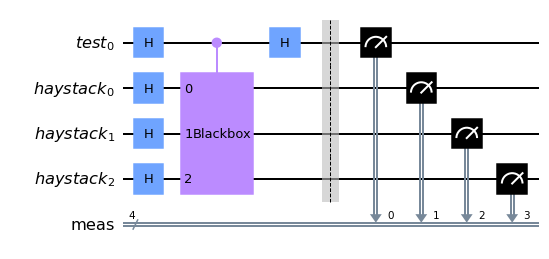

In [4]:
test_register = QuantumRegister(1, 'test')
test = test_register[0]
circuit = QuantumCircuit(test_register, haystack_register)

# equal superpositionを作る（このようにゲート操作のメソッドにレジスタを渡すと、レジスタの各ビットにゲートがかかります。）
circuit.h(haystack_register)

##################
### EDIT BELOW ###
##################
circuit.h(test)

#circuit.?
##################
### EDIT ABOVE ###
##################

circuit.measure_all()

circuit.draw('mpl')

回路が完成したら、{doc}`chsh_inequality`に従って実機で実行し、ヒストグラムをプロットしてください。

In [ ]:
IBMQ.enable_account('__paste_your_token_here__')

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_filter = lambda b: (not b.configuration().simulator) and (b.configuration().n_qubits >= circuit.num_qubits) and b.status().operational
backend = least_busy(provider.backends(filters=backend_filter))

print('Jobs will run on', backend.name())

In [ ]:
job = execute(circuit, backend, shots=8192)
job_monitor(job, interval=2)

result = job.result()
counts = result.get_counts(circuit)

In [ ]:
plot_histogram(counts, figsize=(16, 4))

実機での実行結果が予想と大きく反していたら（ほぼ確実にずれている）、ハードウェアのエラーが起きている可能性があります。そのようなときはシミュレータで回路自体に問題がないか確認します。シミュレータとしては{doc}`circuit_from_scratch`で紹介した`statevector_simulator`を使ってもいいですし（その場合`measure_all()`を除いてください）、`qasm_simulator`という、実機と似た働きをするものを利用することもできます。`qasm_simulator`は回路の測定までをシミュレートするので、実機で実行する場合と同じように位相情報のなくなったヒストグラムデータが出力されます。

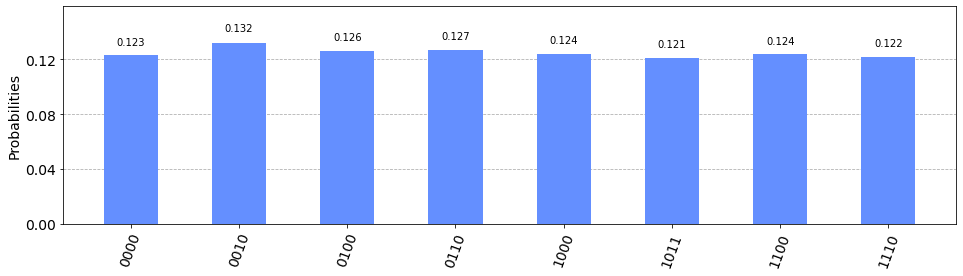

In [10]:
qasm_simulator = Aer.get_backend('qasm_simulator')
simjob = execute(circuit, qasm_simulator, shots=10000)
plot_histogram(simjob.result().get_counts(), figsize=(16, 4))

**提出するもの**

- 完成した回路のコードと実行結果（実機とシミュレータ）のヒストグラム
- ヒストグラムから何が読み取れるかの考察
- `haystack`レジスタが一般の$n$ビットであるとき、この方法で`needle`を探すことの問題点（実行時間の観点から）に関する考察

## 問題2: データ入力とフーリエ変換

実習で量子フーリエ変換

$$
\ket{j} \xrightarrow{\text{Q.F.T.}} \sum_{k=0}^{2^n-1} e^{2 \pi i j k / 2^n} \ket{k}
$$

を紹介しましたが、これだけだとこの変換が何をするのか、まだピンと来ないかもしれません。

ポイントになるのは、この変換操作が全ての$\ket{j}$に対して作用するということです。なので$\ket{j}$に関する重ね合わせからスタートすると

$$
\begin{align}
\sum_{j=0}^{2^n-1} \varphi_{j} \ket{j} \xrightarrow{\text{Q.F.T.}} & \sum_{k=0}^{2^n-1} \sum_{j=0}^{2^n-1} \varphi_{j} e^{2 \pi i j k / 2^n} \ket{k} \\
=: & \sum_{k=0}^{2^n-1} \tilde{\varphi}_k \ket{k}
\end{align}
$$

となり、$\ket{k}$の振幅が$\varphi_{j}$の離散フーリエ変換$\tilde{\varphi}_k = \sum_{j=0}^{N-1} \exp (2\pi i jk/N) \varphi_j$になっていることがわかります。この$\tilde{\varphi}$の計算は、まさに並列性と干渉の両方を利用した教科書的な量子計算とも言えます。

実習で実装したフーリエ変換のコードを利用して、適当な波形のスペクトル分解をしてみましょう。波形は（古典）データとして配列で与えられるので、それをまずは量子状態に焼き直す必要があります。

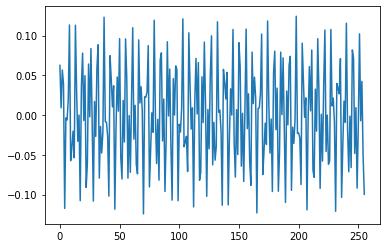

In [22]:
num_qubits = 8
array_length = 2 ** num_qubits

# index array
indices = np.arange(array_length)
# data array = cos(2pi/N * 97 * index) + sin(2pi/N * 43 * index)
data = np.cos(2. * np.pi / array_length * 97 * indices) + np.sin(2. * np.pi / array_length * 43 * indices)
# normalize the data array so sum_i[data_i^2] = 1
data /= np.sqrt(np.sum(np.square(data)))

plt.plot(indices, data)

それでは、この`data`配列が計算基底の振幅に対応するように回路を初期化し、フーリエ変換をしてみましょう。回路の量子ビット数を`num_qubits`のまま組んでみてもいいですし、必要であれば適宜「作業ビット」（計算過程で一時的に情報を書き込んでおくビット）や「補助ビット」（例えばそのビットが$\ket{0}$である部分空間でのみ求める状態が実現しているなど）を足してもOKです。

In [ ]:
circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
#circuit.?

##################
### EDIT ABOVE ###
##################

# QFT
for itarg in range(num_qubits - 1, -1, -1):
    circuit.h(itarg)
    for ictrl in range(itarg - 1, -1, -1):
        power = ictrl - itarg - 1 + num_qubits
        circuit.cp((2 ** power) * 2. * np.pi / (2 ** num_qubits), ictrl, itarg)
        
for i in range(num_qubits // 2):
    circuit.swap(i, num_qubits - 1 - i)
    
circuit.measure_all()

出来上がった回路は間違いなく現在の実機で実行できる範囲の制御ビット数を遥かに超えているので、シミュレーションでのみ評価します。

In [ ]:
qasm_simulator = Aer.get_backend('qasm_simulator')
simjob = execute(circuit, qasm_simulator, shots=10000)
plot_histogram(simjob.result().get_counts(), figsize=(16, 4))

**提出するもの**

- 完成した回路のコードと実行結果（シミュレータ）のヒストグラム
- データ入力部分のアルゴリズムの解説
- 古典データを量子回路に入力する際の問題点（必要なゲート数の観点から）に関する考察